<div id="toc"></div>

In [89]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Goal

Develop a method for slicing `bhp` by $\Delta t_1$ or $\Delta t_2$.

* Load `bhp` (or `bhm` $\rightarrow$ `bhp`)
* Plot `bhp`
* Select by $\Delta t_1$ or $\Delta t_2$
* Plot that distribution

In [103]:
import numpy as np
import scipy.io as sio
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors
import inspect
import seaborn as sns
sns.set(style='ticks')

In [3]:
# Load the bicorr.py functions I have already developed
sys.path.append('../scripts')

import bicorr as bicorr

In [4]:
%load_ext autoreload
%autoreload 2

# Load `det_df`, channel lists

In [5]:
os.listdir('../meas_info/')

['detector_positions.xlsx',
 'det_df.csv',
 'det_df.pkl',
 'det_df_pairs_angles.csv',
 'det_df_pairs_angles.pkl',
 'lanl_detector_angles.mat',
 'lanl_detector_angles_note.md']

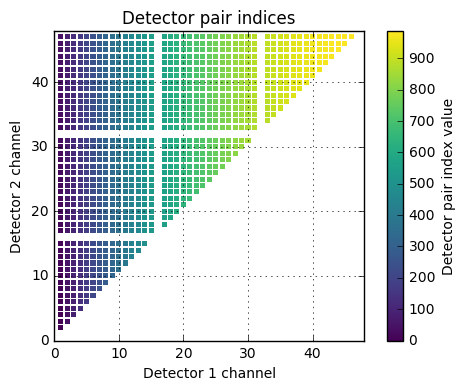

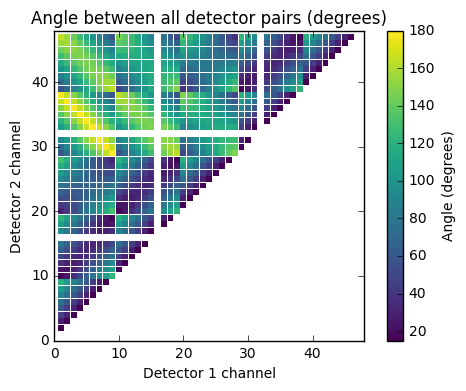

In [6]:
det_df = bicorr.load_det_df('../meas_info/det_df_pairs_angles.csv',plot_flag=True)

In [7]:
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists(print_flag=True)

Fission chamber channels: [ 0 16 32]
Detector channels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Number of detectors: 45
Number of detector pairs: 990


# Load `bhp` data

Do I have a `bhp` distribution saved that I can load directly? I would rather not have to load and revive `bhm` because it requires so much memory.

Work with data from `Cf072115_to_Cf072215b` analysis.

In [8]:
os.listdir('../analysis/Cf072115_to_Cf072215b/')

['.ipynb_checkpoints',
 'analysis.pptx',
 'analysis_bicorr_plots_gifs.html',
 'analysis_bicorr_plots_gifs.ipynb',
 'analysis_counts_v_angle.ipynb',
 'analysis_experimental_setup_figs.html',
 'analysis_experimental_setup_figs.ipynb',
 'analysis_latex',
 'analysis_singles_counts.ipynb',
 'analysis_slices_by_t.ipynb',
 'bhp_all_gif.npz',
 'bhp_nn_gif.npz',
 'datap',
 'fig',
 'flux_run_notes.pptx',
 'singles_hist.npz',
 'sparse_bhm.npz',
 'sparse_bhm_neg.npz']

In [9]:
bhp_nn_gif_data = np.load('../analysis/Cf072115_to_Cf072215b/bhp_nn_gif.npz')
print(bhp_nn_gif_data.files)

['bhp_nn_neg_mean', 'th_bin_edges', 'dt_bin_edges_neg', 'vmax_nn_rel', 'norm_factor', 'vmin_nn', 'dt_bin_edges', 'bhp_nn_pos_mean', 'num_fissions', 'bhp_nn_pos_rel', 'bhp_nn_diff_rel', 'bhp_nn_pos', 'bhp_nn_diff', 'vmax_nn', 'bhp_nn_diff_mean', 'bhp_nn_neg', 'vmin_nn_rel', 'bhp_nn_neg_rel']


In [10]:
norm_factor = bhp_nn_gif_data['norm_factor']
bhp_nn_pos  = bhp_nn_gif_data['bhp_nn_pos']
bhp_nn_neg  = bhp_nn_gif_data['bhp_nn_neg']
bhp_nn_diff = bhp_nn_gif_data['bhp_nn_diff']
th_bin_edges= bhp_nn_gif_data['th_bin_edges']
th_bin_centers = (th_bin_edges[:-1]+th_bin_edges[1:])/2
dt_bin_edges= bhp_nn_gif_data['dt_bin_edges']
dt_bin_edges_neg= bhp_nn_gif_data['dt_bin_edges_neg']

In [11]:
bhp_nn_diff.shape

(9, 800, 800)

Sum along first axis to make distribution across all angles

In [12]:
bhp = np.sum(bhp_nn_diff,axis=0)
bhp.shape

(800, 800)

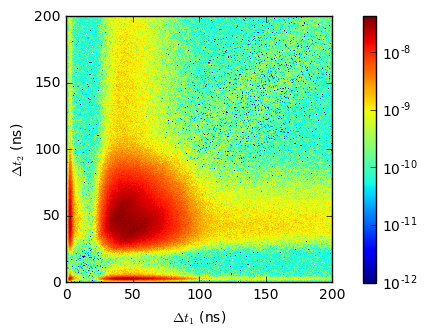

In [13]:
bicorr.bicorr_plot(bhp,dt_bin_edges,show_flag = True, vmin=1e-12)

Coarsen time binning.

In [14]:
bhp, dt_bin_edges = bicorr.coarsen_bhp(bhp, dt_bin_edges, 8, normalized = True, print_flag = True)

Dimensions of bicorr_hist_plot:  (800, 800)
Width of time bin in (ns):  0.25
Width of coarse time bin in (ns):  2.0
Condensing bhp from shape  (800, 800)  to  (100, 100)


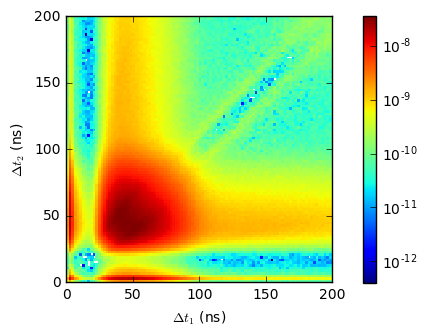

In [15]:
bicorr.bicorr_plot(bhp,dt_bin_edges,show_flag = True)

# Sum along a specific slice for $\Delta t_1$

In [16]:
dt_bin_centers = (dt_bin_edges[:-1]+dt_bin_edges[1:])/2

In [17]:
i = 25
print(dt_bin_edges[i])
print(dt_bin_edges[i+1])
print(dt_bin_centers[i])

50.0
52.0
51.0


In [34]:
t = 51
i = np.digitize(t,dt_bin_edges)-1

In [36]:
print(dt_bin_edges[i])
print(dt_bin_edges[i+1])
print(dt_bin_centers[i])

50.0
52.0
51.0


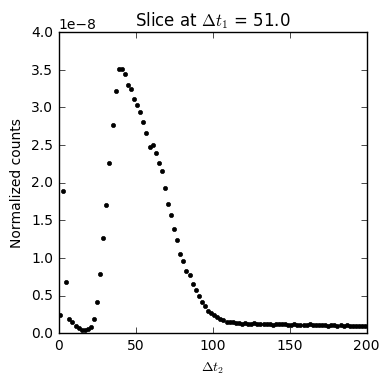

In [37]:
plt.figure(figsize=(4,4))
plt.plot(dt_bin_centers,bhp[i,:],'.k')
plt.xlabel('$\Delta t_2$')
plt.ylabel('Normalized counts')
plt.title('Slice at $\Delta t_1$ = {}'.format(dt_bin_centers[i]))
plt.tight_layout()
plt.show()

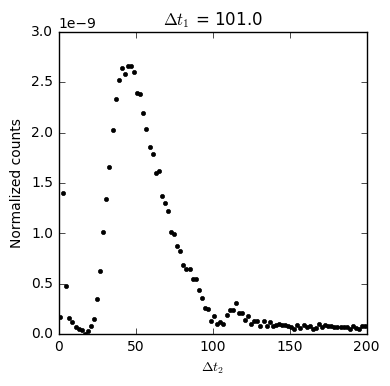

In [20]:
plt.figure(figsize=(4,4))
plt.plot(dt_bin_centers,bhp[i,:],'.k')
plt.xlabel('$\Delta t_2$')
plt.ylabel('Normalized counts')
plt.title('$\Delta t_1$ = {}'.format(dt_bin_centers[i]))
plt.tight_layout()
plt.show()

This works, but I need to work with the full dataset and coarsen the timing.

# Take both slices

The way I am plotting the distribution above, I am holding $\Delta t_1$ constant and looking at $\Delta t_2$. This means that I am looking at the distribution of detctor 2 with detector 1 held constant.

This introduces some bias, or more precisely, removes a biased set of channels from the distribution. 

Since detctor pairs are organizes such that `det1ch < det2ch`, I am looking at the distribution of neutron times for the higher detector channels. 

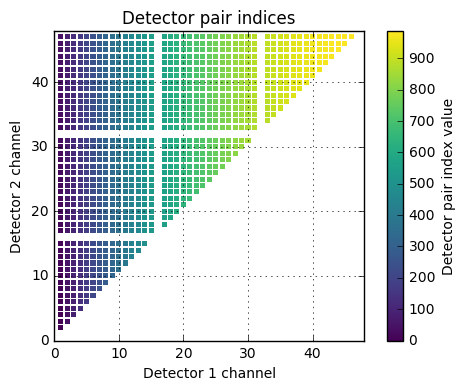

In [22]:
bicorr.plot_det_df(det_df, which='index')

In order to include all data, I need to take the sum of all detectors pairs in *both* directions. Try it out.

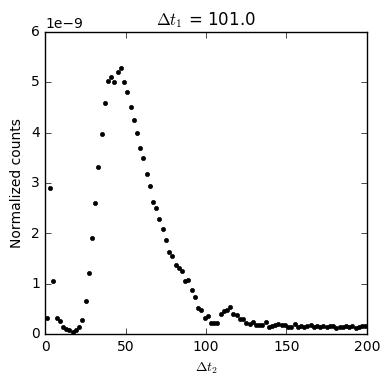

In [23]:
plt.figure(figsize=(4,4))
plt.plot(dt_bin_centers,bhp[i,:]+bhp[:,i],'.k')
plt.xlabel('$\Delta t_2$')
plt.ylabel('Normalized counts')
plt.title('$\Delta t_1$ = {}'.format(dt_bin_centers[i]))
plt.tight_layout()
plt.show()

# Normalize it

In order to compare multiple traces, I need to normalize them either by the peak or the total number. For now I am going to go with the total number. 

Create slices at a few times.

In [92]:
t_slices = [30,50,70,90]

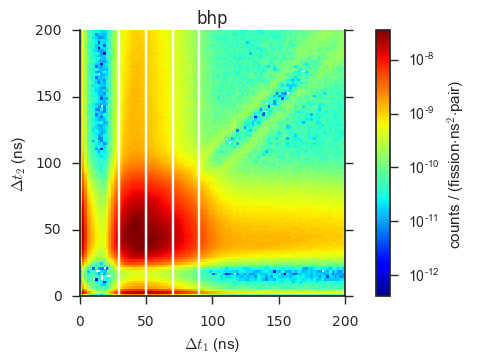

In [93]:
bicorr.bicorr_plot(bhp,dt_bin_edges,title='bhp',clear=False)
for t in t_slices:
    plt.axvline(t,c='w')
plt.show()

In [94]:
bhp_slices = np.zeros((len(t_slices),len(dt_bin_centers)))

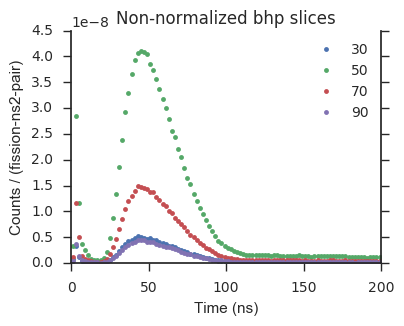

In [105]:
plt.figure(figsize=(4,3))
for t in t_slices:
    i = t_slices.index(t) # Works as long as t_slices is unique
    
    bhp_slices[i,:] = bhp[i,:]+bhp[:,i]
    plt.plot(dt_bin_centers,bhp_slices[i,:],'.')
plt.xlabel('Time (ns)')
plt.ylabel('Counts / (fission-ns2-pair)')
plt.legend([str(t) for t in t_slices])
plt.title('Non-normalized bhp slices')
sns.despine(right=False)
plt.show()

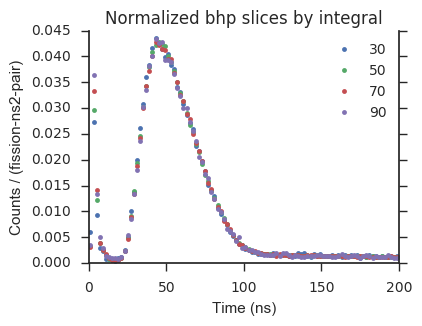

In [107]:
plt.figure(figsize=(4,3))
for t in t_slices:
    i = t_slices.index(t) # Works as long as t_slices is unique
    
    bhp_slices[i,:] = bhp[i,:]+bhp[:,i]
    plt.plot(dt_bin_centers,bhp_slices[i,:]/np.sum(bhp_slices[i,:]),'.')
plt.xlabel('Time (ns)')
plt.ylabel('Counts / (fission-ns2-pair)')
plt.legend([str(t) for t in t_slices])
plt.title('Normalized bhp slices by integral')
sns.despine(right=False)
plt.show()

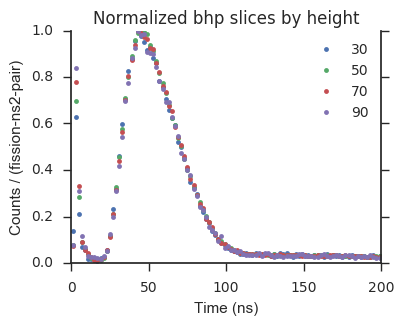

In [108]:
plt.figure(figsize=(4,3))
for t in t_slices:
    i = t_slices.index(t) # Works as long as t_slices is unique
    
    bhp_slices[i,:] = bhp[i,:]+bhp[:,i]
    plt.plot(dt_bin_centers,bhp_slices[i,:]/np.max(bhp_slices[i,:]),'.')
plt.xlabel('Time (ns)')
plt.ylabel('Counts / (fission-ns2-pair)')
plt.legend([str(t) for t in t_slices])
plt.title('Normalized bhp slices by height')
sns.despine(right=False)
plt.show()

# Functionalize it

I want to automate the process for producing this based on a give time stamp. 

In [79]:
bhp_slice = bicorr.slice_bhp(bhp,dt_bin_edges,50.0,53.0,True)

Creating slice through bhp for times from 50.0 to 54.0


In [80]:
bhp_slice.shape

(100,)

In [114]:
help(bicorr.plot_bhp_slice)

Help on function plot_bhp_slice in module bicorr:

plot_bhp_slice(bhp_slice, dt_bin_edges, normalized=None, title=None, show_flag=False, save_flag=False, save_filename='bhp_slice', save_folder='fig', new_fig=True, clear=True)
    Plot bhp slice.
    
    Parameters
    ----------
    bhp_slice : ndarray
        Slice through bhp at delta_tj_min, produce with slice_bhp()
    dt_bin_edges : ndarray
        One-dimensional array of time bin edges
    normalized : str
        None: Don't normalize
        'int': Normalize by integral
        'max': Normalize by height
    title : str
        Title for plot. Ex: '$\Delta t_j$ = {}'.format(dt_bin_centers[i])
    show_flag : bool
        Option to show figure
    save_flag : bool
        Option to save figure to file
    save_filename : str
        filename where to save figure
    save_folder : str
        foldername where to save figure  
    new_fig : bool, optional
        option to open new fig (if False, plots on existing axes)
    clea

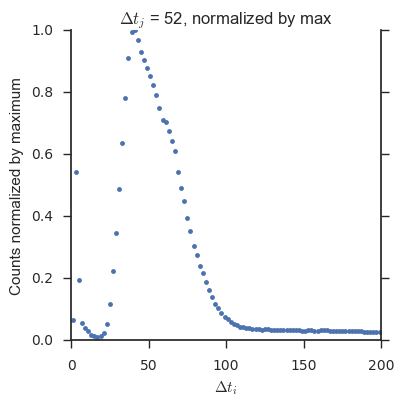

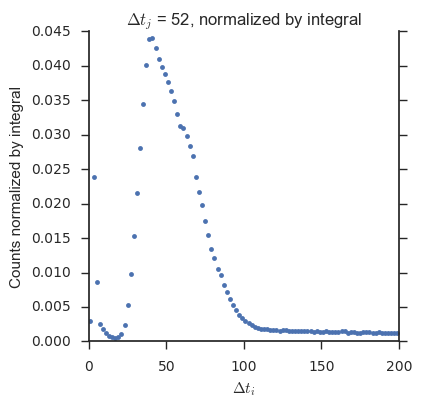

In [122]:
bicorr.plot_bhp_slice(bhp_slice, dt_bin_edges, show_flag = True, 
                      title='$\Delta t_j$ = {}, normalized by max'.format(52),
                      normalized='max')
bicorr.plot_bhp_slice(bhp_slice, dt_bin_edges, show_flag = True, 
                      title='$\Delta t_j$ = {}, normalized by integral'.format(52),
                      normalized='int')

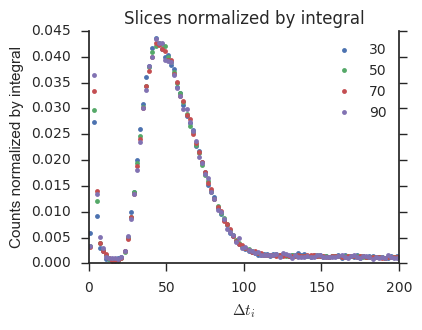

In [126]:
plt.figure(figsize=(4,3))
for t in t_slices:
    i = t_slices.index(t) # Works as long as t_slices is unique
    bicorr.plot_bhp_slice(bhp_slices[i,:],dt_bin_edges,normalized='int',clear=False,new_fig=False)

plt.legend([str(t) for t in t_slices])
plt.title('Slices normalized by integral')
plt.show()